## Setup

In [1]:
# install dependencies
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [12]:
# variables
KURTOSIS_WINDOW = "1825D"
DATA_FILE = 'crsp.csv'
FAMA_FRENCH_FACTORS = 'F-F_Research_Data_Factors.csv'

In [ ]:
# preprocessing

src = pd.read_csv(DATA_FILE)

src = src[['permno', 'comnam', 'date', 'prc', 'ret']]

src['ret'] = pd.to_numeric(src['ret'], errors='coerce')
src = src.dropna(subset=['ret'])

src['date'] = pd.to_datetime(src['date'], format='%Y%m%d')

/tmp/ipykernel_18115/3467151320.py:3: DtypeWarning: Columns (5,6,7,10,18,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  src = pd.read_csv(DATA_FILE)


In [ ]:
# define functions
def calculate_kurtosis(frame: pd.DataFrame):
    frame['kurtosis'] = None 

    for _, group in frame.groupby('permno'):
        k = group.set_index('date')['ret'].rolling(window=KURTOSIS_WINDOW).kurt()
        frame.loc[group.index, 'kurtosis'] = k.values

    return frame.dropna(subset=['kurtosis'])

def assign_quantiles(data: pd.DataFrame, field):
    sorted_df = data.sort_values(by=field)
    sorted_df['quantile'] = pd.qcut(sorted_df[field], q=10, labels=False)
    return sorted_df

In [24]:
def mean_return(portfolio: pd.DataFrame):
    return portfolio['ret'].mean()

In [53]:
# creating portfolios for next month
def create_portfolio(data: pd.DataFrame, long: list, short: list):
    quantiles = assign_quantiles(data, "kurtosis")

    portfolio = pd.concat(quantiles[quantiles['quantile'] == q] for q in (long + short))
    portfolio = portfolio[['permno', 'comnam', 'date']]

    return portfolio 

In [6]:
# define famma french
def fama_french(data: pd.DataFrame):
    # Load Fama-French factors
    factors = pd.read_csv(FAMA_FRENCH_FACTORS)
    factors['Date'] = pd.to_datetime(factors['Date'], format='%Y%m')
    
    data['month_year'] = data['date'].dt.to_period('M')
    factors['month_year'] = factors['Date'].dt.to_period('M')

    factors = factors[factors['month_year'].isin(data['month_year'])]

    # Keep only necessary columns and ensure consistent naming
    factors = factors[['month_year', 'MKT_RF', 'SMB', 'HML', 'RF']]

    print(factors.head())
    # Adjust scale of factors
    factors['MKT_RF'] = factors['MKT_RF'] / 100
    factors['SMB'] = factors['SMB'] / 100
    factors['HML'] = factors['HML'] / 100
    factors['RF'] = factors['RF'] / 100

    # Merge Fama-French factors with stock data
    regression_in = pd.merge(data, factors, on='month_year', how='left')

    # Compute excess return
    regression_in['excess_return'] = regression_in['ret'] - regression_in['RF']

    # Prepare regression variables
    X = regression_in[['MKT_RF', 'SMB', 'HML']]
    X = X.apply(pd.to_numeric, errors='raise')
    X = sm.add_constant(X, has_constant='add')

    y = pd.to_numeric(regression_in['excess_return'], errors='raise')

    # Run regression
    model = sm.OLS(y, X).fit()
    return model

In [56]:
# define portfolio evaluation strategy
def evaluate_portfolio(portfolio: pd.DataFrame, next_month: pd.DataFrame):
    # ovaj portfolio za mjesec n+1

    portfolio = pd.merge(portfolio, next_month[['permno', 'ret', 'dlret']], on='permno', how='left')
    portfolio['next_month_return'] = portfolio['ret'].fillna(portfolio['dlret']).fillna(0)

    print(portfolio.head())

    fama_french(portfolio)

## Experiment

In [13]:
# calculate kurtosis
df = calculate_kurtosis(src)

In [ ]:
# Extract unique months
df['month_year'] = df['date'].dt.to_period('M')
df = df[df['month_year'] >= pd.Period('1926-07', freq='M')]
months = df['month_year'].unique()


/tmp/ipykernel_18115/3889112599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month_year'] = df['date'].dt.to_period('M')


##### Plotted curtosis of 15 stocks (1990-2025)

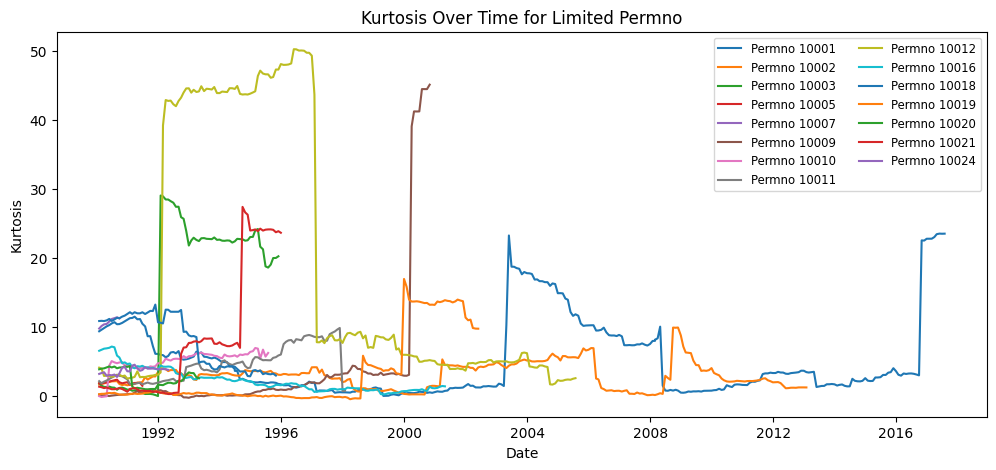

In [52]:
def plot_kurtosis_over_time_limited_filtered(data, limit=15):
    plt.figure(figsize=(12, 5))  
    filtered_data = data[(data['date'] >= '1990-01-01') & (data['date'] <= '2025-12-31')]
    for permno, group in filtered_data.groupby('permno'):
        plt.plot(group['date'], group['kurtosis'], label=f'Permno {permno}')
        limit -= 1
        if limit == 0:
            break
    plt.xlabel('Date')
    plt.ylabel('Kurtosis')
    plt.title('Kurtosis Over Time for Limited Permno')
    plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.show()

# Plot kurtosis 
plot_kurtosis_over_time_limited_filtered(df)

##### Mean return of each quantile (all-time)

In [ ]:
# measure mean return of quantiles through time 

for i in range(10):
    mean_returns = []

    # Iterate over unique months
    for month in months:
        month_data = df[df['month_year'] == month]
        quantiles = assign_quantiles(month_data, "kurtosis")
        mean_returns.append(quantiles[quantiles['quantile'] == i]['ret'].mean())

    print(f"Mean return (all time) - Q{i+1}: ", pd.Series(mean_returns).mean())

Mean return (all time) - Q1:  0.009380065609653182
Mean return (all time) - Q2:  0.009763674060574191
Mean return (all time) - Q2:  0.009763674060574191
Mean return (all time) - Q3:  0.01047035311285352
Mean return (all time) - Q3:  0.01047035311285352
Mean return (all time) - Q4:  0.010273376784541197
Mean return (all time) - Q4:  0.010273376784541197
Mean return (all time) - Q5:  0.010339890504906383
Mean return (all time) - Q5:  0.010339890504906383
Mean return (all time) - Q6:  0.010607880254958284
Mean return (all time) - Q6:  0.010607880254958284
Mean return (all time) - Q7:  0.011131351936451081
Mean return (all time) - Q7:  0.011131351936451081
Mean return (all time) - Q8:  0.012475684504976723
Mean return (all time) - Q8:  0.012475684504976723
Mean return (all time) - Q9:  0.015439600932335387
Mean return (all time) - Q9:  0.015439600932335387
Mean return (all time) - Q10:  0.029843379623027404
Mean return (all time) - Q10:  0.029843379623027404


Appears that quantiles with higher curtosis, when viewed as portfolios, perform better than quantiles with lower curtosis.

#### Portfolio generation

In [ ]:
# generate long and short portfolios

for month in months[:-1]:
    next_month = month + 1
    month_data = df[df['month_year'] == month]
    next_month_data = df[df['month_year'] == next_month]

    portfolio_small = create_portfolio(month_data, [9], [0])
    portfolio_large = create_portfolio(month_data, [9,8], [0,1])

    # Evaluate portfolios
    evaluate_portfolio(portfolio_small, next_month_data)
    evaluate_portfolio(portfolio_large, next_month_data)


Mean returns for portfolio (long Q10, short Q1):  0.010231657006687113
Mean returns for portfolio (long Q10 & Q9, short Q1, Q2):  0.006534810221283855


##### Misc

In [ ]:
# generate portfolio for next month (from now)
month = months[-1]
month_data = df[df['month_year'] == month]

portfolio_small = create_portfolio(month_data, [9], [0])
portfolio_large = create_portfolio(month_data, [9,8], [0,1])

print("Portfolio Small:", portfolio_small.head())
print("Portfolio Large:", portfolio_large.head())